# m.5.ASSIGNment → Spooky authorship identification via Apache Spark

### Group 6: Tyler Earps, Basil Mullings, Ryan Smith, and Ean Vandergraaf

| Overview      | Use Apache Spark and machine learning to determine sentence authorship labels. |
| ------------- | ------------------------------------------------------------------------------ |
| Data          | https://www.kaggle.com/competitions/spooky-author-identification/code          |


<figure>
    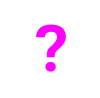
    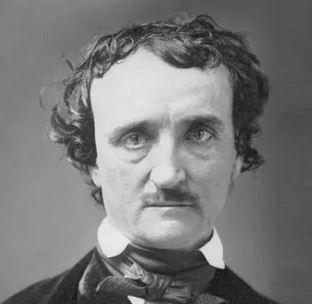
    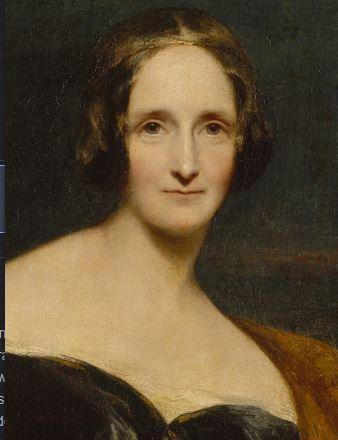
    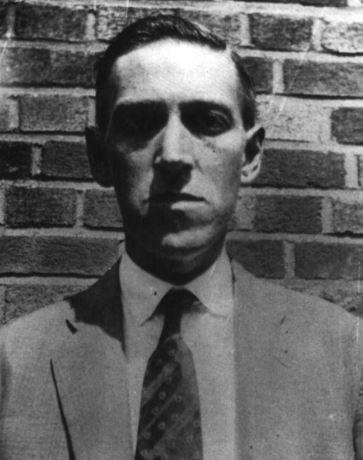
</figure>


## DETAILS

**Dataset Description**: The spooky author identification dataset contains text from works of
fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary
Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt
sentence tokenizer resulting in an odd non-sentence here and there. Your objective is to
accurately identify the author of the sentences in the test set.

- **id** - unique identifier for each sentence
- **text** - sentence written by one of the authors
- **author** - {EAP:Edgar Allan Poe}, {HPL:HP Lovecraft}; {MWS:Mary Wollstonecraft Shelley}

**Objective**:
1. Accurately identify the author of the sentences in the test set.
2. Perform ALL work using Apache Spark.

**Dataset**:
- Training consists of passages with an author label.
- Test has sentences with no author labels.

**Competition Evaluation**: The submissions were evaluated based on multi-class logarithmic loss.
The logarithmic loss assesses the uncertainty of the predicted probabilities, penalizing
confident incorrect predictions. Lower log loss values indicated better performance.

**Approach**: NLP techniques + machine learning algorithms. Feature engineering like bag-of-words,
TF-IDF, word embeddings/Word2Vec. Perform algorithmic work with logistic regression, support
vector machines, neural networks, and as appropriate.

## TASKS

### Stage 0: Import Data

1. Create a code notebook called: code_6_of_10_data_mine_<your_name>.ipynb
2. Load data into Spark data objects and explore structure, size, and distribution of information.

In [ ]:
# Download the data
# If you haven't installed the Kaggle API, uncomment the line below to do so
# %pip install kaggle
!kaggle competitions download -c spooky-author-identification -p data/

In [ ]:
import zipfile
from pathlib import Path
from pyspark.sql import SparkSession

# Extract the CSV files
data_path = "data"
if not Path(f"{data_path}/test.zip").is_file():
    with zipfile.ZipFile(f"{data_path}/spooky-author-identification.zip", 'r') as zipped_data:
        zipped_data.extractall(f"{data_path}/")
    with zipfile.ZipFile(f"{data_path}/train.zip", 'r') as zipped_data:
        zipped_data.extractall(f"{data_path}/")
    with zipfile.ZipFile(f"{data_path}/test.zip", 'r') as zipped_data:
        zipped_data.extractall(f"{data_path}/")

#Create a SparkSession
spark = SparkSession.builder.getOrCreate()

#Load Kaggle data into a DataFrame
df = spark.read.format("csv").option("header", "true").load(f"{data_path}/train.csv")

# Show the data
df.show()


### Stage 1: Data Preparation - Exploratory data analysis and text mining pre-processing

3. Perform exploratory data analysis and create visualizations and tables as needed.
4. Text Preprocessing: perform tasks like tokenization and stopwords removal to clean text data.
    1. Tokenize - split the text into individual words aka tokens.
    2. Remove stop.words - frequently used pronouns and personal references.
        1. Top ten include: I, you, he, she, it, we, they, me, him, her
    3. Lemmatization - convert words to their root (optional).
        1. Lemmatization is a text normalization technique that reduces words to their base or
dictionary form (lemma). Use to reduce inflected or derived words to their root form for
better analysis and modeling outcomes.

In [ ]:
from pyspark.ml.feature import StopWordsRemover, Tokenizer
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline

# Step 1: Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
# Step 2: Stop word removal
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
'''
Step.1 replace "text" in Tokenizer(inputCol="text", outputCol="tokens")
with the actual column name from your CSV file that contains the text data.
'''

### Stage 2: Feature Extraction

5. Perform TF-IDF to quantify word importance <[term.frequency.inverse.doc.frequency](https://en.wikipedia.org/wiki/Tf–idf)>
6. Normalize is scaling or standardizing the numerical features to a standard range or distribution.
    1. In text mining, normalization vectorizes features with methods like TF-IDF, a numerical
measurement, to ensure a consistent scale.
    2. It handles variations in the magnitude of feature values impacting machine-learning algorithm
performance. Normalize the features to ensure a similar scale and prevent features with larger
values from dominating the analysis or modeling process.

In [ ]:
# Step 3: TF-IDF calculation
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="vectorized_tokens")
idf = IDF(inputCol="vectorized_tokens", outputCol="tfidf")
# Step 4: Normalization
normalizer = Normalizer(inputCol="tfidf", outputCol="normalized_features")
# Step 5: Create pipeline for chaining the text mining transformers
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer, idf, normalizer])
# Step 6: Apply the pipeline to DataFrame
processed_data = pipeline.fit(your_dataframe).transform(your_dataframe)
'''
step.4 The processed_data object will contain the final processed features in the
"normalized_features" column. use for machine learning tasks.
Step.6 replace your_dataframe with the name of your DataFrame that holds the CSV data.
'''

### Stage 3: Machine Learning

7. Perform train/test split.
8. Perform algorithmic analysis to assess and predict test labels.
    1. Use as many algorithms as you need to get a good answer.
    2. Supervised: logistic regression, random forest, support vector machines, etc.
    3. Unsupervised: K-means, dimensionality reduction, PCA, etc.

### Stage 4: Evaluation & Visualization

9. Choose a metric strategy to assess algorithmic performance like accuracy, precision, recall, or F1 score.
10. Visualize confusion matrix, correlations, and similar.
11. Identify important features contributing to classification.
12. Write a 2-3 sentence minimum of findings, learnings, and what you would do next.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover, Tokenizer, CountVectorizer, IDF
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

    1. Tokenizer to split part of the pyspark.ml.feature module
    2. StopWordsRemover in the pyspark.ml.feature module.
    3. lemmatization - PySpark does not have a built-in lemmatization use User-Defined
    Functions UDF to create.
    4. normalize like convert text to lowercase; remove special characters with PySpark user
    defined functions <UDF> or built-in string functions like lower() or regexp_replace().
    5. tf.idf PySpark's CountVectorizer and IDF class compute tf.idf for text feature
    extraction.

#### Resources
- [How to Assess Algorithm Fit](https://github.com/cosc-526/home.page/blob/86eac9b60052cdb5959c0e9fa96b7e7f3a3fcdd9/how.To.M.5.algorithm.Assess.fit.super.unsuper.pdf)
- [PySpark Code Dictionary](https://github.com/cosc-526/home.page/blob/2d9505d38a2b76ce61991fc59223f511aef34472/reference.library.pyspark.code.dictionary.pdf)
- [pd.DataFrame vs. rdd.DataFrame](https://github.com/cosc-526/home.page/blob/c7bc526297dc72517a270df22d4f8109c8cae149/cheatsheet.pyspark.RDD.feng.utk.pdf)
- [Cheat Sheet for PySpark](https://github.com/cosc-526/home.page/blob/c7bc526297dc72517a270df22d4f8109c8cae149/cheatsheet.pyspark.feng.utk.pdf)
- [Additional PySpark Guide](https://github.com/cosc-526/home.page/blob/c7bc526297dc72517a270df22d4f8109c8cae149/cheatsheet.python.feng.utk.pdf)
- [Cheat Sheet for LaTeX](https://github.com/cosc-526/home.page/blob/c7bc526297dc72517a270df22d4f8109c8cae149/cheatsheet.LaTeX.feng.utk.pdf)
- [Apache Spark Source Documentation](https://spark.apache.org/docs/latest/index.html)
- Feng, W. (2021). [Learning Apache Spark with Python](https://runawayhorse001.github.io/LearningApacheSpark/pyspark.pdf). GitHub.

#### Additional Resources
- Feng, W., & Chen, M. (2017). [Learning Apache Spark](https://mingchen0919.github.io/learning-apache-spark/index.html). GitHub.
- Karau, H., Konwinski, A., Wendell, P., & Zaharia, M. (2015). Learning Spark: Lightning-fast
big data analysis. O’Reilly Media, Inc.
- Kirillov, A. (2016). [Apache Spark: Core concepts, architecture and internals](http://datastrophic.io/core-concepts-architecture-and-internals-of-apache-spark/).
Datastrophic.
